# Movie2vec
---

Item2Items style similarity Word2vec style....


## MovieLens : turning ratings into sentences
---

movielens is a familiar open dataset that has different information (tags etc) over it's many iterations but at base always gives us a list of users, movies, ratings and a timestamp for that rating. 


Here we will modifiy the task on the movielens dataset to find movie similarity instead of predicting a user rating rating as is usually the done. We will be training a word2vec skipgram model with negative sampling but obvously our data is not structured like text. 

After trying several methods I got the best results using the following method:

   - First : data is sorted grouped by user and sorted based on each user's movie interactions first by `rating` and then by `timestamp`. These values are then discarded as they are encoded in the user's sequence.  
   
   
   - During training : At each step we take a single user sequence and grab points from within a moving relative window (Where commonly this would be of fixed size for flat text data), to generate our batch. Negative sampling is allowed to happen outside of these points.
   
   


In [523]:
import os
import random
import zipfile
import re
import math
import urllib


# essentials
import numpy as np
import pandas as pd
import tensorflow as tf


#viz
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook
%matplotlib inline

# import our skipgram model
from skip_gram_model import SkipGramModel

In [26]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### data in

get the [MovieLens 20 million ratings dataset](https://grouplens.org/datasets/movielens/20m/) here...

uncomment the line below to unzip the movielens dataset...

In [3]:
# zipfile.ZipFile('data/ml-20m.zip').extractall(path='data/')

In [212]:
data_dir = 'data/ml-20m'

# read ratings and movies into dataframes
ratings = pd.read_csv(os.path.join(data_dir, 'ratings.csv'))
movies = pd.read_csv(os.path.join(data_dir, 'movies.csv'))

In [213]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [214]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [215]:
counts = ratings.movieId.value_counts()

# filter out movies only in dataset once
ratings = ratings.loc[ratings.movieId.isin(counts.loc[(counts > 1)].index)]


we'll replace the movie id with an integer representing it's freqency and make a dictionary with the new id and the movie name.

In [216]:
# make a dictionary of old_id2 moviename
id_2_movie_name = dict(movies[['movieId', 'title']].values)

# make a dictionary mapping of new id (based on frequency) and the moviename
# by convention we'll let reserve 0 in case we want to use this for masking
# in the future...
id2idx = {k:i+1 for i, (k, v) in enumerate(ratings.movieId.value_counts().items())}
# id2idxmake a dictionary of to new moviename
dictionary = {id2idx[k]: id_2_movie_name[k] for k in id2idx}
id2idx[0] = 'null'
dictionary[0] = 'null'
reverse_dictionary = {v:k for k,v in dictionary.items()}

ratings = ratings.loc[ratings.movieId.isin(id2idx)]
ratings.movieId = ratings.movieId.apply(lambda x : id2idx[x])

# delete the id_2_movie_name & the movies frame we won't need them anymore
del id_2_movie_name
del movies

I'll also define a really simple fuzzy lookup interface to the dictionary so that we can look up movie names without putting in year or being exact about their titles....

In [9]:
movie_series = pd.Series(dictionary)

def fuzzy_movie_lookup(movie_str, dat=movie_series):
    """query a movie name using a regex string
    return all matches and their indexes.
    """
    return dat.loc[dat.str.contains(movie_str, flags=re.IGNORECASE)]
    
    
    

We can sort each users movie choices by `rating` and then by `timestamp` so that when we generate values within a window the users positive and negative preferences will be reflected as well as a bit about the order in which they watched them. 

In [10]:
data =[]

for key, chunk in ratings.groupby('userId'):
    data.append(chunk.sort_values(['rating', 'timestamp']).movieId.values)



### generator

make a generator for data using each 'user' as a document. 

In [35]:
def get_batch(seq, rel_window_size=.2):
    """get a batch of data for a single user sequence.
    data will be chosen randomly from within a moving 
    window relative to the size of the entire sequence. 
    with the initial point chosen at random.
    """
    window = math.floor(len(seq) * rel_window_size) +1
    x = []
    y = []
    i = random.randint(0, len(seq)-1)
    for _ in range(batch_size):
        x.append(seq[i])
        moves = list(range(max(i-window, 0), i)) + list(range(i+1, min((i+window + 1, len(seq)))))
        j = random.choice(moves)
        y.append(seq[j])
        i = j
    return x, y            
            
def gen_batch(data, batch_size, rel_window_size=.2, shuffle=True):
    """make a generator for data using each 'user' as a document."""
    while True:
        for doc_index, doc in enumerate(data):
            x, y = get_batch(doc, rel_window_size)
            yield np.array(x, 'int32'), np.expand_dims(np.array(y,'int32'), 1)
        if shuffle:
            random.shuffle(data)


### sample films to `watch` during training:

define a set of validation films to watch as we train, these lot have been chosen from the top most popular movies

In [36]:
val_films = ['Little Mermaid, The (1989)', 
             'Princess Mononoke (Mononoke-hime) (1997)', 
             'Three Musketeers, The (1993)',
             'Addams Family Values (1993)', 
             'NeverEnding Story, The (1984)',
             'Gone with the Wind (1939)',
             'Police Academy (1984)',
             'Transformers (2007)',
             'Streetcar Named Desire, A (1951)',
             'Star Trek: First Contact (1996)',
             'Miracle on 34th Street (1994)',
             'Third Man, The (1949)',
             'Last Samurai, The (2003)',
             'Sleeper (1973)',
             'Poltergeist (1982)'
            ]

val_ids = [reverse_dictionary[s] for s in val_films]

I like this particular validation set as it's easy to see when the model has converged because of what I'll call the Ghibli metric :)

    batch 1 :
    
    Nearest to Princess Mononoke (Mononoke-hime) (1997):
    
                        My Favorite Brunette (1947),
                        Coma (1978),
                        Raid (2003),
                        Hell's Kitchen (1998),
                        Let it Come Down: The Life of Paul Bowles (1998),
                        
                        
    batch 260000:
    
    Nearest to Princess Mononoke (Mononoke-hime) (1997):
    
                        My Neighbor Totoro (Tonari no Totoro) (1988),
                        Spirited Away (Sen to Chihiro no kamikakushi) (2001),
                        Howl's Moving Castle (Hauru no ugoku shiro) (2004),
                        Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986),
                        Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984),



For fun I'll also add some of my own favorite sleeper picks in there. I'm purposly choose a few less well known films here so the model should have a tougher time with these.

In [37]:
print(fuzzy_movie_lookup(r'Forbidden Zone'))
val_ids.append(9030)

6782    Spacehunter: Adventures in the Forbidden Zone ...
9030                                Forbidden Zone (1980)
dtype: object


In [38]:
print(fuzzy_movie_lookup(r'Hausu'))
val_ids.append(8787)

8787    House (Hausu) (1977)
dtype: object


In [39]:
print(fuzzy_movie_lookup(r'Solaris')) 
# we want the original tarkovsky version for sure!
val_ids.append(1946)


1616               Solaris (2002)
1946    Solaris (Solyaris) (1972)
dtype: object


In [40]:
print(fuzzy_movie_lookup(r'shadows of our forgotten ancestors')) 
# we want the original tarkovsky version for sure!
val_ids.append(11060)

11060    Shadows of Our Forgotten Ancestors (Tini zabut...
dtype: object


In [243]:
val_set = np.array(val_ids, 'int32')


### build model

In [516]:
# valid_examples = np.array(random.sample(range(1, valid_window+1), valid_size))
vocab_size = len(dictionary)
batch_size = 128
embedding_size = 256  # Dimension of the embedding vector.
val_size =len(val_set)

lr = 1.


model = SkipGramModel(vocab_size, val_set, embedding_dims=256, 
                      batch_size=batch_size, sample_factor=1., lr=lr, optimizer= tf.train.AdagradOptimizer)


### training

In [517]:
# create the data generator
data_gen = gen_batch(data, batch_size, rel_window_size = .2, shuffle=True)

In [518]:
steps_per_cycle = (len(data) // batch_size)
n_iter = 200 # number of full cycles through data
num_steps = int(n_iter * steps_per_cycle)
lstep = steps_per_cycle # steps to show average loss
vstep = steps_per_cycle * 20  # steps to show val data

def show_n_similar(item, sim, k=5):                
    item_name = dictionary[item]
    nearest = (-sim).argsort()[1:k + 1]
    log_str = '\nNearest to - {}:\n'.format(item_name)
    for k in range(k):
        log_str += '\t{},\n'.format(dictionary[nearest[k]])
    print(log_str)

    
losses = []

with tf.Session() as sess:
    sess.run(model.init_op())
    print('initialized ...')
    # set so we can watch average loss during training

    for step in tqdm_notebook(range(num_steps)):
        batch_inputs, batch_labels = next(data_gen)
        feed_dict = {model.x: batch_inputs, 
                     model.y: batch_labels}
        
        _, loss_ = sess.run([model.optimize, model.loss], feed_dict=feed_dict)
        losses.append(loss_) # for plotting
        
    sim = model.similarity.eval()

    for i in range(len(val_ids)):
        show_n_similar(model.val_data[i], sim[i], k=5)
    
    out_embeddings = model.normalized_embeddings.eval()


#     uncomment to save model to a directory 'logs'

#     saver = model.saver()       
#     spath = 'logs/movie2vec_{}.ckpt'
#     saver.save(sess=sess, save_path=spath.format(step))
#     print('Model saved in file: {}'.format(spath))



initialized ...




Nearest to - Little Mermaid, The (1989):
	Splash (1984),
	Rocky Horror Picture Show, The (1975),
	Grease (1978),
	Wedding Singer, The (1998),
	It's a Wonderful Life (1946),


Nearest to - Princess Mononoke (Mononoke-hime) (1997):
	Spirited Away (Sen to Chihiro no kamikakushi) (2001),
	My Neighbor Totoro (Tonari no Totoro) (1988),
	Howl's Moving Castle (Hauru no ugoku shiro) (2004),
	Seven Samurai (Shichinin no samurai) (1954),
	Fight Club (1999),


Nearest to - Three Musketeers, The (1993):
	Casper (1995),
	First Knight (1995),
	Johnny Mnemonic (1995),
	Naked Gun 33 1/3: The Final Insult (1994),
	Nine Months (1995),


Nearest to - Addams Family Values (1993):
	Cliffhanger (1993),
	Santa Clause, The (1994),
	Waterworld (1995),
	Clear and Present Danger (1994),
	While You Were Sleeping (1995),


Nearest to - NeverEnding Story, The (1984):
	Lady and the Tramp (1955),
	Spaceballs (1987),
	Tron (1982),
	Goonies, The (1985),
	Time Bandits (1981),


Nearest to - Gone with the Wind (1939):
	

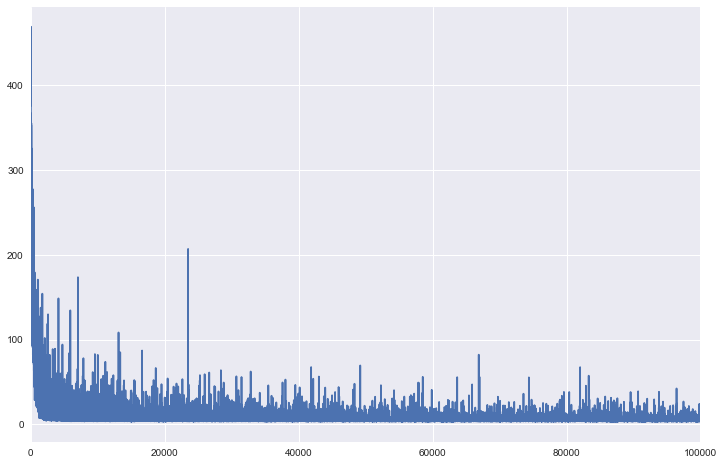

In [519]:
pd.Series(losses[:100000]).plot(kind='line', figsize=(12, 8)); plt.show()

we can save the final embeddings along with our movie and index dictionarys and load these as weights for the item embedding half of a customer x model based model or compute user similarities entirely based on their product reccomendations, which in  a situation where the number of users grows at a higher rate than the number of products is very useful.


# Plot

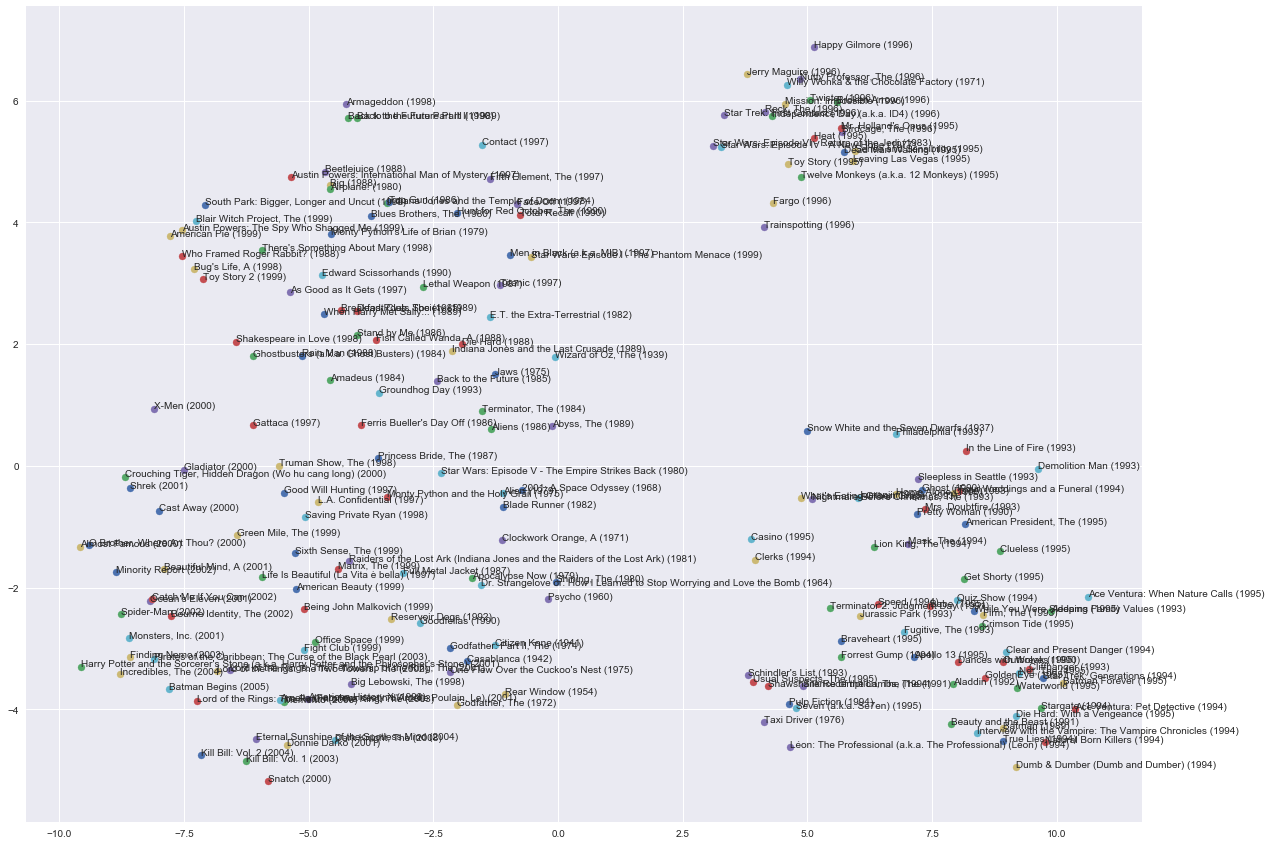

In [520]:
def plot(embeddings, labels):
    plt.figure(figsize=(20, 15)) 
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y))
        
        
r = np.arange(1, 200+1)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100)
t = tsne.fit_transform(out_embeddings[r, :])
plot(t, [dictionary[i] for i in r])


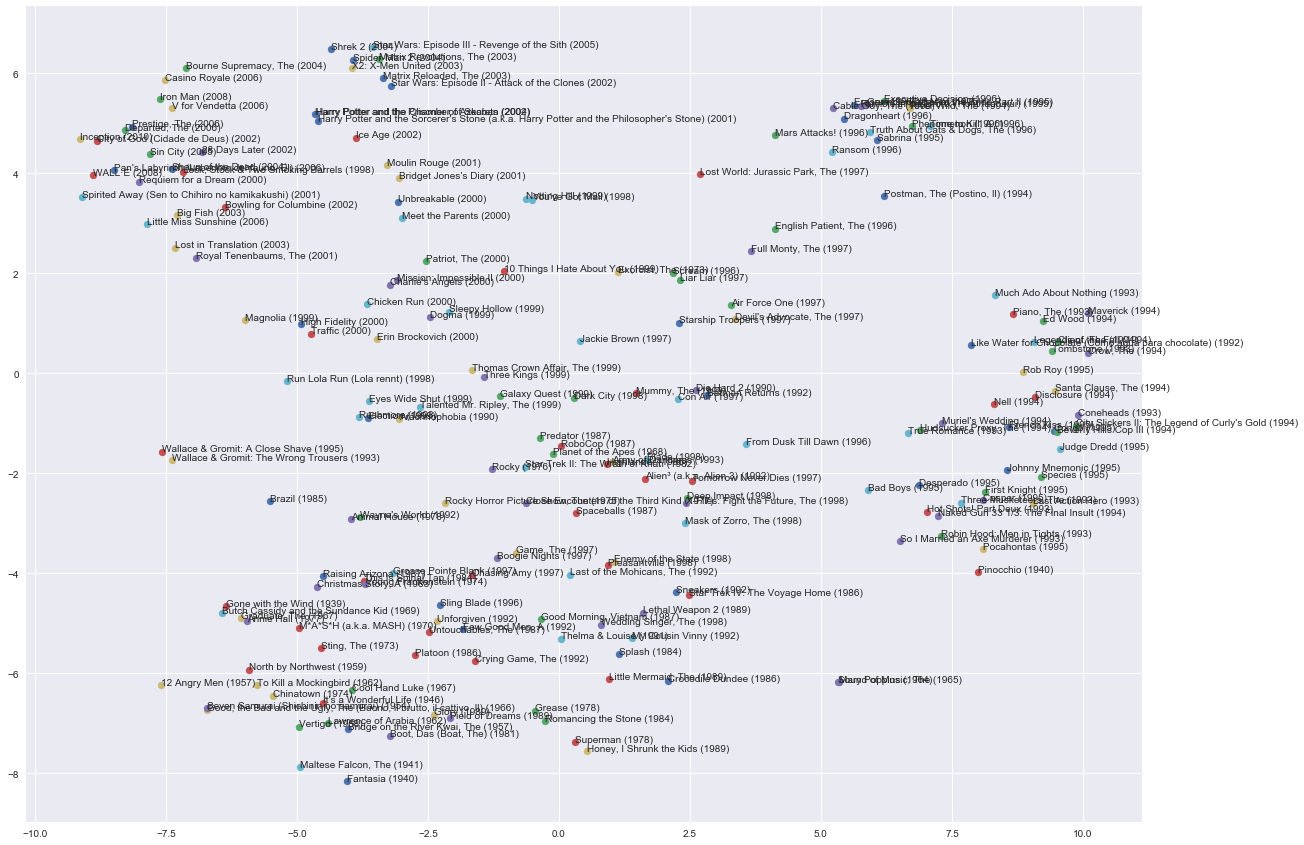

In [521]:
r = np.arange(200, 400+1)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100)
t = tsne.fit_transform(out_embeddings[r, :])
plot(t, [dictionary[i] for i in r])


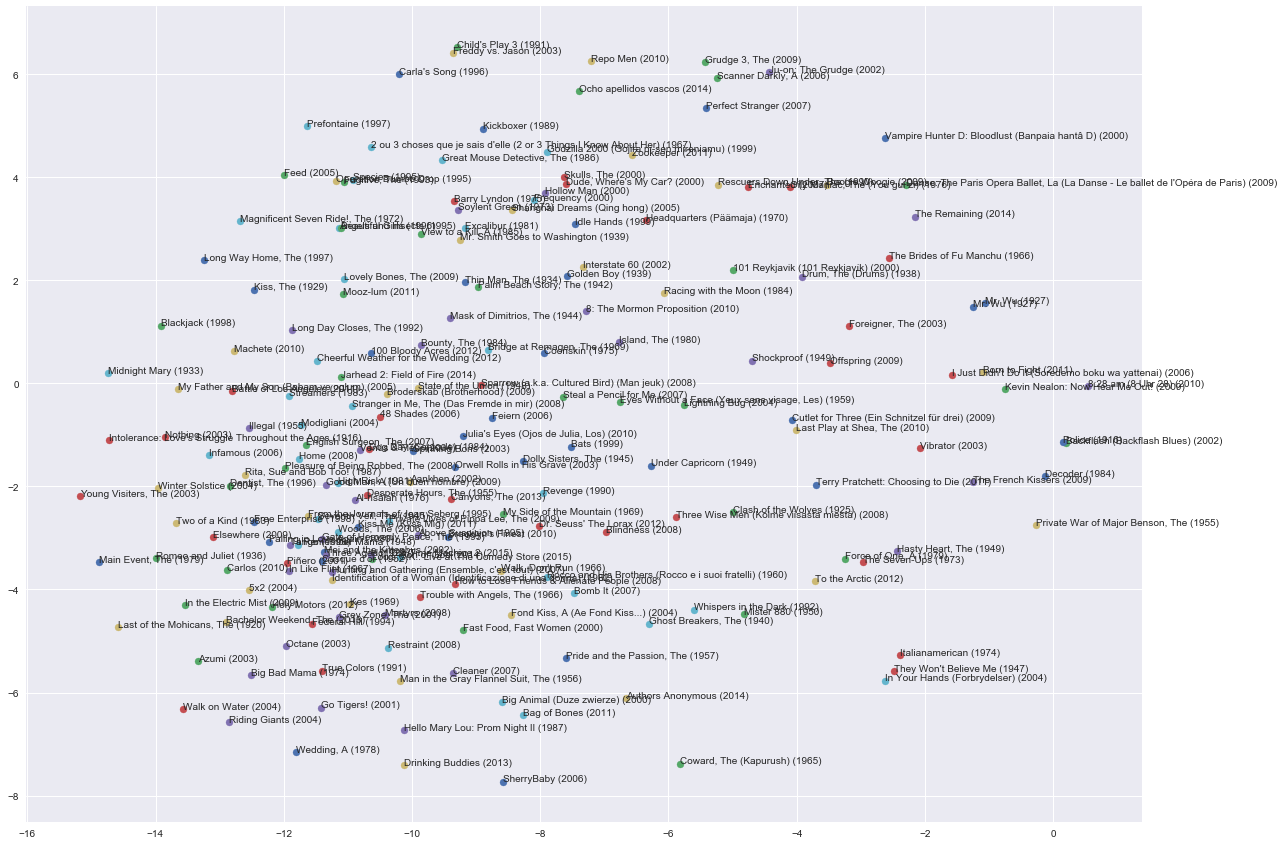

In [522]:
r = np.random.choice(range(1, out_embeddings.shape[0]), 200)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100)
t = tsne.fit_transform(out_embeddings[r, :])
plot(t, [dictionary[i] for i in r])


# post script - the best movie titles I found while training :

---

after adding in my semi-obscure favorites i started to get some real winners:



- He Died With a Felafel in His Hand (2001)
- Teknolust (2002) 
- Mega Shark vs. Crocosaurus (2010) *
- Day of the Wacko (Dzien swira) (2002)
- Mother, Jugs & Speed (1976)
- Grand Theft Parsons (2003)
- Brain That Wouldn't Die, The (1962)
- Sex Lives of the Potato Men (2004)


* at first i red this as *Chocosaurus* which would have been better...